## Import Libraries

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

## Parameter Settings


In [2]:
latent_dims = 2
num_epochs = 30
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

We will use MNIST as always. Fill the required lines

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Define the image transformation (converting images to tensors)
img_transform = transforms.Compose([
    transforms.ToTensor()
])

# Loading the MNIST training dataset
train_dataset = MNIST(root='./data', train=True, transform=img_transform, download=True)

# Creating a DataLoader for the training dataset
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Loading the MNIST test dataset
test_dataset = MNIST(root='./data', train=False, transform=img_transform, download=True)

# Creating a DataLoader for the test dataset
test_dataloader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16153799.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483652.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4427045.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3965555.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Variational Autoencoder (VAE) Implementation

This code defines a Variational Autoencoder (VAE) using PyTorch. A VAE is a type of generative model that learns to encode input data into a latent space, then decode it back to the original data distribution.

### **Encoder Class**

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)  # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)  # out: c*2 x 7 x 7

        # Assuming input image size is 28x28, the final feature map after conv layers is (c*2 x 7 x 7) = (128 x 7 x 7) if capacity=64
        # The output from conv layers must be flattened before passing to fully connected layers
        self.fc_mu = nn.Linear(c * 2 * 7 * 7, latent_dims)  # Fully connected layer for mu
        self.fc_logvar = nn.Linear(c * 2 * 7 * 7, latent_dims)  # Fully connected layer for log variance

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # flatten batch of multi-channel feature maps to a batch of feature vectors

        # Pass the flattened features to fully connected layers
        x_mu = self.fc_mu(x)  # Predict mean (mu)
        x_logvar = self.fc_logvar(x)  # Predict log variance (logvar)

        return x_mu, x_logvar


### **Decoder Class**

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        # Fully connected layer to expand the latent vector to a feature map
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)

        # Transpose Convolution layers (reverse of Encoder)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)  # upsample to 14x14
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)  # upsample to 28x28

    def forward(self, x):
        # Expand the latent vector into a feature map using the fully connected layer
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)  # Reshape to (batch_size, c*2, 7, 7)

        # Pass through transpose convolutional layers
        x = F.relu(self.conv2(x))  # Upsample to (batch_size, c, 14, 14)
        x = self.conv1(x)  # Upsample to (batch_size, 1, 28, 28)

        # Apply sigmoid activation to get output suitable for BCE loss
        x = torch.sigmoid(x)

        return x


### **VariationalAutoencoder Class**

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        # Define the Encoder and Decoder instances
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Pass the input through the encoder to get mu and logvar
        latent_mu, latent_logvar = self.encoder(x)

        # Sample from the latent space using the reparameterization trick
        latent = self.latent_sample(latent_mu, latent_logvar)

        # Decode the latent variable back to reconstruct the image
        x_recon = self.decoder(latent)

        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # Reparameterization trick: sample from N(mu, var)
            std = logvar.mul(0.5).exp_()  # Calculate the standard deviation from log variance
            eps = torch.empty_like(std).normal_()  # Sample epsilon from a standard normal distribution
            return eps.mul(std).add_(mu)  # Return mu + std * epsilon
        else:
            # During inference, just return the mean as the latent vector
            return mu


### **Loss Function (`vae_loss`)**

In [7]:
def vae_loss(recon_x, x, mu, logvar):

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [8]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE
--------

In [9]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
# Set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:
        # Move the input data to the device (GPU or CPU)
        image_batch = image_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the VAE to get reconstructed image, mu, and logvar
        recon_batch, mu, logvar = vae(image_batch)

        # Compute the loss
        loss = vae_loss(recon_batch, image_batch, mu, logvar)

        # Backpropagation
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Track the training loss
        train_loss_avg[-1] += loss.item()
        num_batches += 1

    # Calculate average loss per batch for the epoch
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))


Training ...
Epoch [1 / 30] average reconstruction error: 23810.729469
Epoch [2 / 30] average reconstruction error: 21490.084799
Epoch [3 / 30] average reconstruction error: 20864.018551
Epoch [4 / 30] average reconstruction error: 20513.179104
Epoch [5 / 30] average reconstruction error: 20288.367198
Epoch [6 / 30] average reconstruction error: 20105.589373
Epoch [7 / 30] average reconstruction error: 19969.155559
Epoch [8 / 30] average reconstruction error: 19848.506584
Epoch [9 / 30] average reconstruction error: 19751.714654
Epoch [10 / 30] average reconstruction error: 19656.652914
Epoch [11 / 30] average reconstruction error: 19574.662609
Epoch [12 / 30] average reconstruction error: 19499.366961
Epoch [13 / 30] average reconstruction error: 19441.645747
Epoch [14 / 30] average reconstruction error: 19390.267232
Epoch [15 / 30] average reconstruction error: 19329.967444
Epoch [16 / 30] average reconstruction error: 19286.382090
Epoch [17 / 30] average reconstruction error: 19235.

Plot Training Curve
--------------------

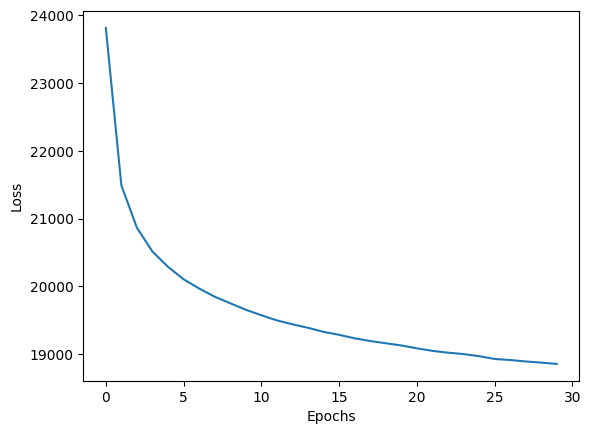

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
-------------------------

In [12]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19100.976031


Visualize Reconstructions
--------------------------

Original images


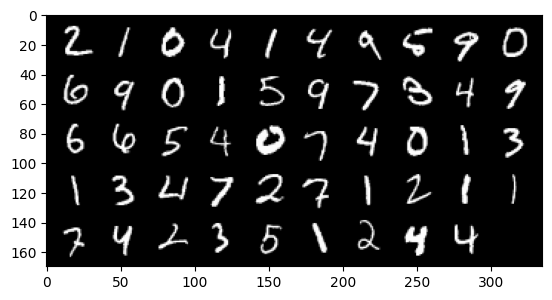

VAE reconstruction:


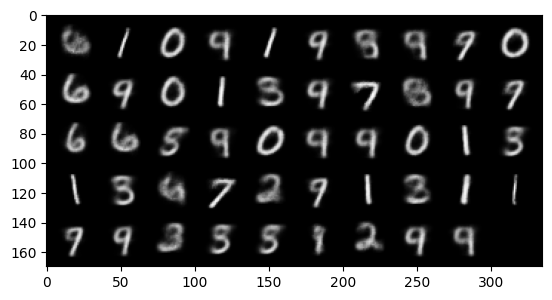

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct and the name of the model with which the reconstructions are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

In [14]:
def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        # Move the images to the device (GPU or CPU)
        img1 = img1.to(device)
        img2 = img2.to(device)

        # Get the mu values (mean of the latent space distributions) from the encoder
        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)

        # Use mu directly as the latent space sample (ignoring logvar)
        latent1 = mu1
        latent2 = mu2

        # Weighted average of the two latent vectors based on lambda1
        inter_latent = lambda1 * latent1 + (1 - lambda1) * latent2

        # Reconstruct the interpolated image from the latent space
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()  # Move the output back to the CPU

        return inter_image


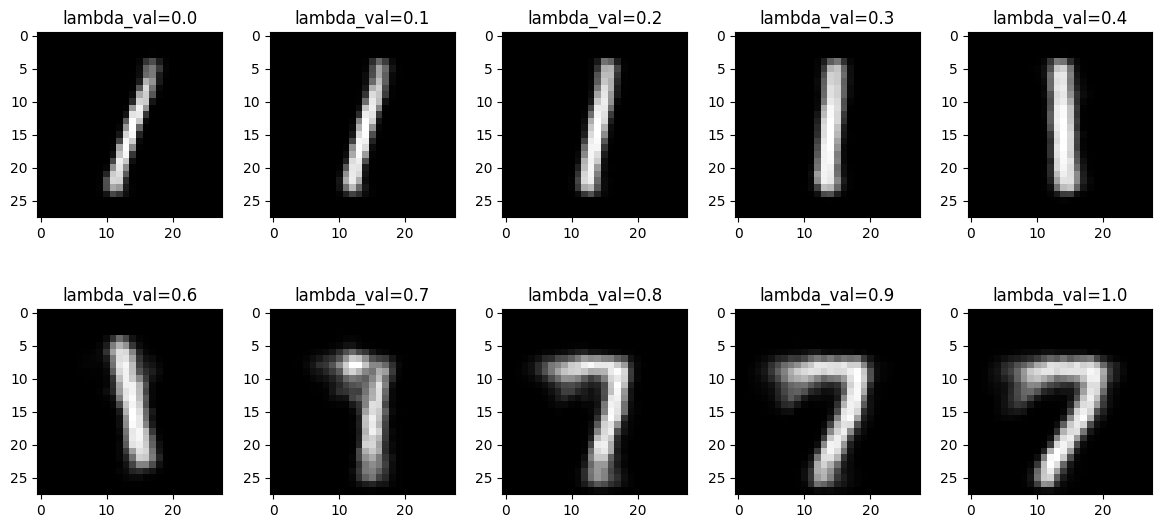

In [15]:
vae.eval()

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Show 2D Latent Space
---------------------

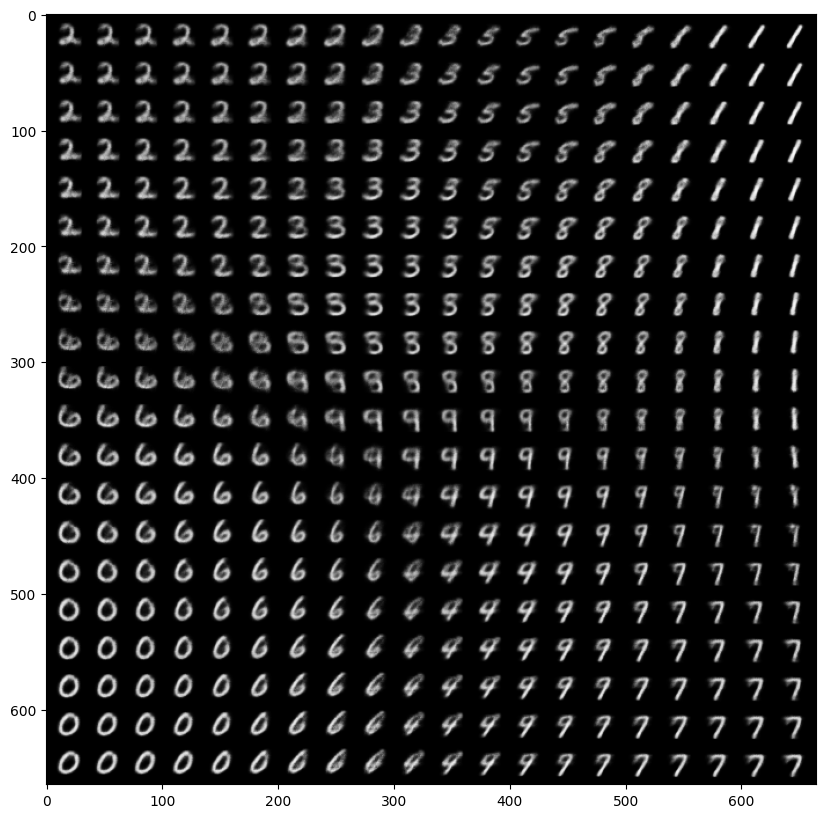

In [16]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()